This file contains the following
1. EDA of TSLA stock data and news articles for 2022
2. Initial tests with existing Sentiment Analysis models such as Text Blob, Vader, Bag of Words Vectorization-based Models
3. Trained Transformer-based Models
4. Trained TBM model for just title
4. SA Correlations between the title of an article with the whole article (log returns and volume)

## TSLA stock price change

In [8]:
import pandas as pd
import numpy as np 

stock_news = 'tsla_news.csv'
stock_data = 'tsla_data.csv'
stock_tkr = 'TSLA'

stock_file = pd.read_csv(stock_news, index_col=0)
stock_file['date'] = pd.to_datetime(stock_file['date'])
stock_file = stock_file.sort_values(by='date')
stock_file = stock_file.reset_index(drop=True)

merged_stock = pd.read_csv(stock_data)
merged_stock['Date'] = pd.to_datetime(merged_stock['Date'])

merged_stock = pd.merge(stock_file, merged_stock, left_on='date', right_on='Date', how='inner')
merged_stock = merged_stock.drop(columns=['Date'])


merged_stock["daily_log_returns"] = np.log(merged_stock['Close']/merged_stock['Open'])

# shift daily log returns and volume
merged_stock["daily_log_returns"] = merged_stock["daily_log_returns"].shift(-1)
merged_stock["Volume"] = merged_stock["Volume"].shift(-1)

merged_stock = merged_stock.dropna(subset=["daily_log_returns"]).reset_index(drop=True)


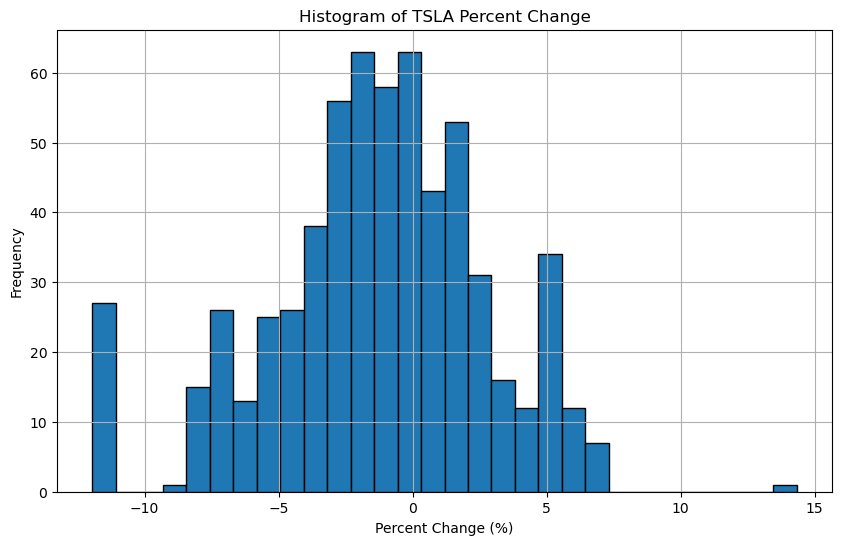

In [9]:
import matplotlib.pyplot as plt

# Calculate the percent increase/decrease in price
merged_stock['percent_change'] = ((merged_stock['Close'] - merged_stock['Open']) / merged_stock['Open']) * 100

# Plot histogram of percent change
plt.figure(figsize=(10, 6))
plt.hist(merged_stock['percent_change'], bins=30, edgecolor='black')
plt.xlabel('Percent Change (%)')
plt.ylabel('Frequency')
plt.title('Histogram of ' + stock_tkr + ' Percent Change')
plt.grid(True)
plt.show()

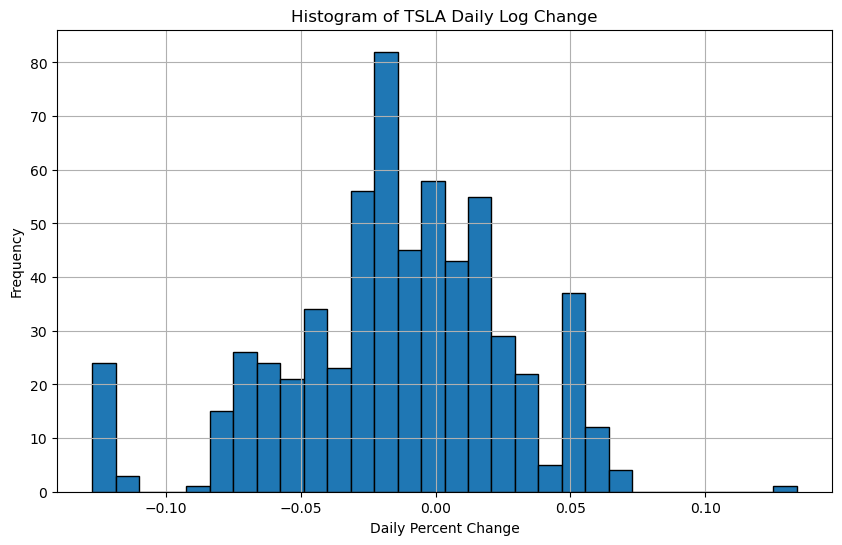

In [10]:
# Plot histogram of daily_percent_change
plt.figure(figsize=(10, 6))
plt.hist(merged_stock['daily_log_returns'], bins=30, edgecolor='black')
plt.xlabel('Daily Percent Change')
plt.ylabel('Frequency')
plt.title('Histogram of ' + stock_tkr + ' Daily Log Change')
plt.grid(True)
plt.show()

In [11]:
merged_stock.head()

,date,source,title,link,content,Open,High,Low,Close,Volume,daily_log_returns,percent_change
0,2022-01-03,The New York Observer,"Tesla Crushed Every Expectation in 2021, Kicki...",https://www.proquest.com/usnews/docview/261613...,A Tesla Model X on display at the 3rd China In...,382.58,400.36,378.68,399.93,"97,209,777",-0.072459,4.534999
1,2022-01-13,Wall Street Journal (Online),"Elon Musk, Hollywood Actors Criticize Californ...",https://www.proquest.com/usnews/docview/261928...,\nA proposal to cut incentives for rooftop sol...,369.69,371.87,342.18,343.85,"72,924,421",0.028734,-6.989640
2,2022-01-14,Wall Street Journal (Online),Elon Musk-Backed EV Battery Technology Rises t...,https://www.proquest.com/usnews/docview/261953...,\nA less-expensive battery technology champion...,339.96,350.67,337.79,349.87,"66,989,401",0.003792,2.915049
3,2022-01-18,USA Today (Online),World's 10 richest men double wealth in the pa...,https://www.proquest.com/usnews/docview/262073...,As the rest of the world suffered financially ...,342.20,356.93,338.69,343.50,"66,989,401",0.003792,0.379895
4,2022-01-18,The New York Observer,Elon Musk Reacts to Tesla Competitor’s Sunday ...,https://www.proquest.com/usnews/docview/262090...,The Dawn Project’s full-page advertisement in ...,342.20,356.93,338.69,343.50,"152,375,129",0.027504,0.379895


# Various sentiment analysis results
- Text Blob
- Vader
- Bag of Words Vectorization-based Models
- LSTM-based Models
- Transformer-based Models


## Text Blob analysis

In [12]:
from textblob import TextBlob
merged_stock['text_blob'] = merged_stock['content'].apply(lambda text: TextBlob(text).sentiment.polarity)

In [13]:
merged_stock.columns

Index(['date', 'source', 'title', 'link', 'content', 'Open', 'High', 'Low',
       'Close', 'Volume', 'daily_log_returns', 'percent_change', 'text_blob'],
      dtype='object')

In [14]:
corr_tb = np.corrcoef(merged_stock["daily_log_returns"], merged_stock["text_blob"])
print(corr_tb)

[[ 1.         -0.05313286]
 [-0.05313286  1.        ]]


In [15]:
# Remove commas from the 'Volume' column
merged_stock["Volume"] = merged_stock["Volume"].str.replace(',', '')

# Convert to numeric (to handle any non-numeric values that might still be present)
merged_stock["Volume"] = pd.to_numeric(merged_stock["Volume"], errors='coerce')

# Fill NaN values or handle them as needed
merged_stock["Volume"] = merged_stock["Volume"].fillna(0)  # Or use dropna

# Convert to integer
merged_stock["Volume"] = merged_stock["Volume"].astype(int)

corr_tb_vol = np.corrcoef(merged_stock["Volume"], merged_stock["text_blob"])
print(corr_tb_vol)

[[ 1.         -0.07589035]
 [-0.07589035  1.        ]]


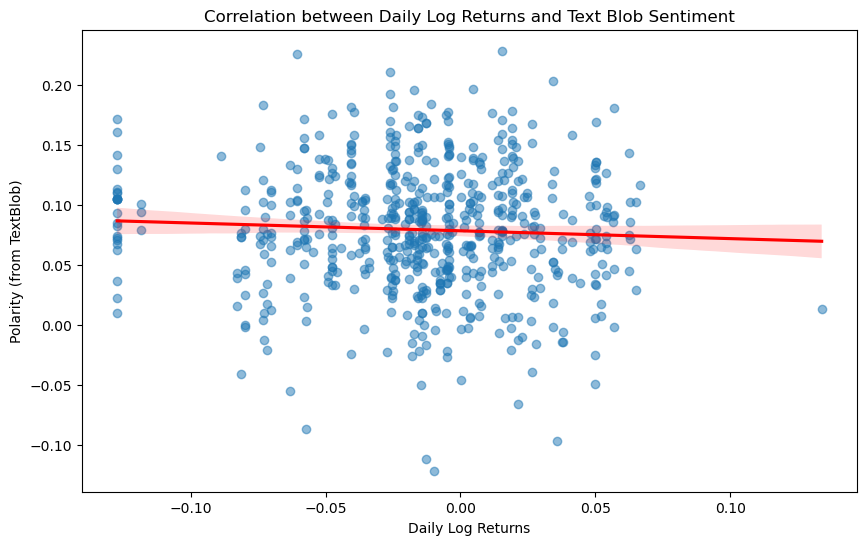

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot with a regression line to visualize the correlation
plt.figure(figsize=(10, 6))
sns.regplot(x=merged_stock["daily_log_returns"], y=merged_stock["text_blob"], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Add labels and title
plt.xlabel("Daily Log Returns")
plt.ylabel("Polarity (from TextBlob)")
plt.title("Correlation between Daily Log Returns and Text Blob Sentiment")

# Display the plot
plt.show()


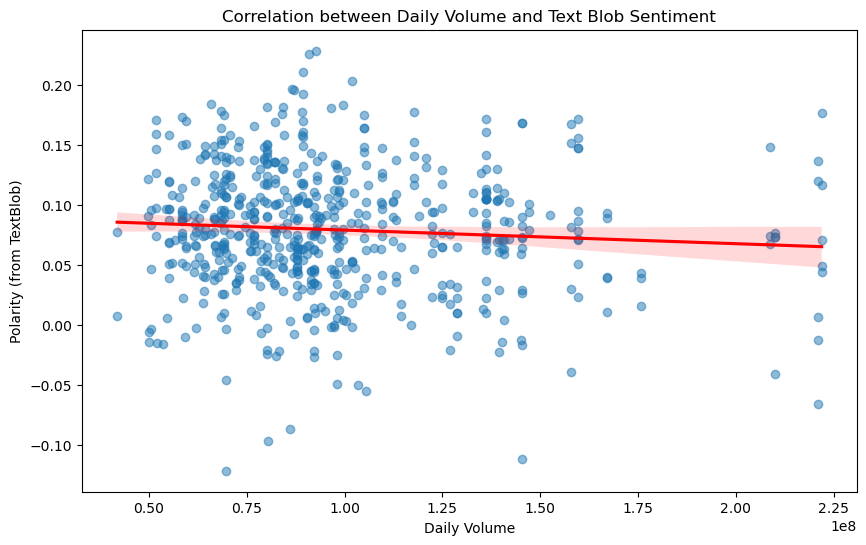

In [17]:
# Create a scatter plot with a regression line to visualize the correlation
plt.figure(figsize=(10, 6))
sns.regplot(x=merged_stock["Volume"], y=merged_stock["text_blob"], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Add labels and title
plt.xlabel("Daily Volume")
plt.ylabel("Polarity (from TextBlob)")
plt.title("Correlation between Daily Volume and Text Blob Sentiment")

# Display the plot
plt.show()


## VADER (Valence Aware Dictionary and Sentiment Reasoner)

In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the Vader sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Apply Vader sentiment analysis to extract only the 'compound' score for each row
merged_stock['vader'] = merged_stock['content'].apply(lambda text: sentiment_analyzer.polarity_scores(text)['compound'])

In [19]:
merged_stock.head(5)

,date,source,title,link,content,Open,High,Low,Close,Volume,daily_log_returns,percent_change,text_blob,vader
0,2022-01-03,The New York Observer,"Tesla Crushed Every Expectation in 2021, Kicki...",https://www.proquest.com/usnews/docview/261613...,A Tesla Model X on display at the 3rd China In...,382.58,400.36,378.68,399.93,97209777,-0.072459,4.534999,0.090058,0.3340
1,2022-01-13,Wall Street Journal (Online),"Elon Musk, Hollywood Actors Criticize Californ...",https://www.proquest.com/usnews/docview/261928...,\nA proposal to cut incentives for rooftop sol...,369.69,371.87,342.18,343.85,72924421,0.028734,-6.989640,0.040181,0.9210
2,2022-01-14,Wall Street Journal (Online),Elon Musk-Backed EV Battery Technology Rises t...,https://www.proquest.com/usnews/docview/261953...,\nA less-expensive battery technology champion...,339.96,350.67,337.79,349.87,66989401,0.003792,2.915049,0.066459,0.9691
3,2022-01-18,USA Today (Online),World's 10 richest men double wealth in the pa...,https://www.proquest.com/usnews/docview/262073...,As the rest of the world suffered financially ...,342.20,356.93,338.69,343.50,66989401,0.003792,0.379895,0.065909,0.9912
4,2022-01-18,The New York Observer,Elon Musk Reacts to Tesla Competitor’s Sunday ...,https://www.proquest.com/usnews/docview/262090...,The Dawn Project’s full-page advertisement in ...,342.20,356.93,338.69,343.50,152375129,0.027504,0.379895,0.091639,0.5932


In [20]:
corr_tb = np.corrcoef(merged_stock["daily_log_returns"], merged_stock["vader"])
print(corr_tb)

[[ 1.         -0.02313343]
 [-0.02313343  1.        ]]


In [21]:
corr_tb_vol = np.corrcoef(merged_stock["Volume"], merged_stock["vader"])
print(corr_tb_vol)

[[ 1.         -0.07662868]
 [-0.07662868  1.        ]]


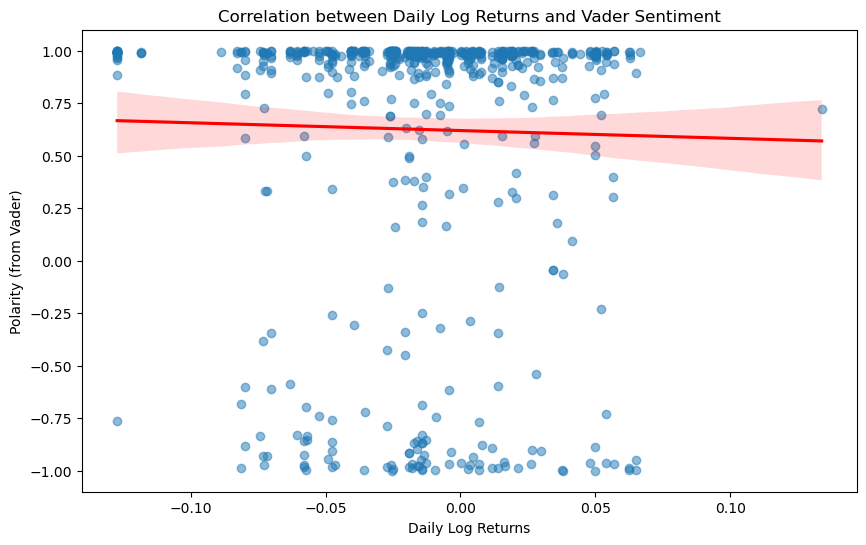

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot with a regression line to visualize the correlation
plt.figure(figsize=(10, 6))
sns.regplot(x=merged_stock["daily_log_returns"], y=merged_stock["vader"], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Add labels and title
plt.xlabel("Daily Log Returns")
plt.ylabel("Polarity (from Vader)")
plt.title("Correlation between Daily Log Returns and Vader Sentiment")

# Display the plot
plt.show()

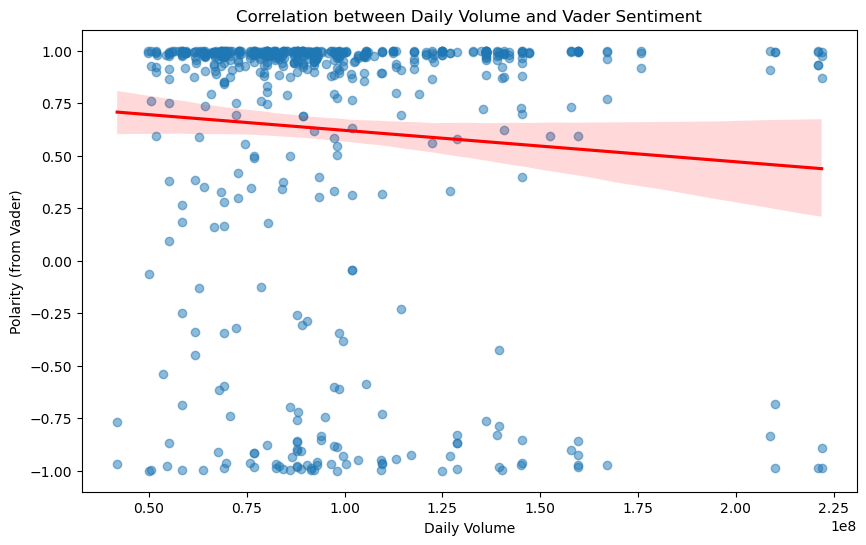

In [23]:
# Create a scatter plot with a regression line to visualize the correlation
plt.figure(figsize=(10, 6))
sns.regplot(x=merged_stock["Volume"], y=merged_stock["vader"], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Add labels and title
plt.xlabel("Daily Volume")
plt.ylabel("Polarity (from Vader)")
plt.title("Correlation between Daily Volume and Vader Sentiment")

# Display the plot
plt.show()

# Bag of Words Vectorization-Based Models

In [24]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Load financial data
data = pd.read_csv('financial_data.csv')

# Pre-processing and Bag of Words Vectorization using CountVectorizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1), tokenizer=token.tokenize)
text_counts = cv.fit_transform(data['Sentence'])

# Splitting the data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, data['Sentiment'], test_size=0.25, random_state=5)

# Training the model
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

# Calculating the accuracy score of the model
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ", accuracy_score)

# Now use the trained model on merged_stock['content']
# Assuming merged_stock is a pandas DataFrame with a 'content' column
# Vectorize merged_stock['content'] using the same CountVectorizer
merged_stock_counts = cv.transform(merged_stock['content'])

# Predict sentiment using the trained Naive Bayes model
predicted_sentiments = MNB.predict(merged_stock_counts)

# Map sentiment labels to numeric values: -1 for negative, 0 for neutral, 1 for positive
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
merged_stock['BOW'] = [sentiment_mapping[sentiment] for sentiment in predicted_sentiments]

# Check the first few rows with the BOW sentiment predictions
merged_stock.head(15)


/Users/madelynmao/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy Score:  0.6851471594798083


,date,source,title,link,content,Open,High,Low,Close,Volume,daily_log_returns,percent_change,text_blob,vader,BOW
0,2022-01-03,The New York Observer,"Tesla Crushed Every Expectation in 2021, Kicki...",https://www.proquest.com/usnews/docview/261613...,A Tesla Model X on display at the 3rd China In...,382.58,400.36,378.68,399.93,97209777,-0.072459,4.534999,0.090058,0.3340,1
1,2022-01-13,Wall Street Journal (Online),"Elon Musk, Hollywood Actors Criticize Californ...",https://www.proquest.com/usnews/docview/261928...,\nA proposal to cut incentives for rooftop sol...,369.69,371.87,342.18,343.85,72924421,0.028734,-6.989640,0.040181,0.9210,0
2,2022-01-14,Wall Street Journal (Online),Elon Musk-Backed EV Battery Technology Rises t...,https://www.proquest.com/usnews/docview/261953...,\nA less-expensive battery technology champion...,339.96,350.67,337.79,349.87,66989401,0.003792,2.915049,0.066459,0.9691,0
3,2022-01-18,USA Today (Online),World's 10 richest men double wealth in the pa...,https://www.proquest.com/usnews/docview/262073...,As the rest of the world suffered financially ...,342.20,356.93,338.69,343.50,66989401,0.003792,0.379895,0.065909,0.9912,0
4,2022-01-18,The New York Observer,Elon Musk Reacts to Tesla Competitor’s Sunday ...,https://www.proquest.com/usnews/docview/262090...,The Dawn Project’s full-page advertisement in ...,342.20,356.93,338.69,343.50,152375129,0.027504,0.379895,0.091639,0.5932,0
5,2022-01-24,Wall Street Journal (Online),Tesla Countersues JPMorgan in Fight Over Warra...,https://www.proquest.com/usnews/docview/262227...,\nTesla Inc. countersued JPMorgan Chase & Co. ...,301.59,311.17,283.82,310.00,86595900,0.004584,2.788554,0.043004,-0.9358,-1
6,2022-01-25,USA Today (Online),Elon Musk says he'll eat a Happy Meal if McDon...,https://www.proquest.com/usnews/docview/262265...,Elon Musk tweeted on Tuesday that he would eat...,304.73,317.09,301.07,306.13,86595900,0.004584,0.459423,0.196140,0.9948,0
7,2022-01-25,Wall Street Journal (Online),Elon Musk Urges McDonald's to Accept Dogecoin ...,https://www.proquest.com/usnews/docview/262248...,\nElon Musk wants McDonald's Corp. to start ac...,304.73,317.09,301.07,306.13,104867283,-0.015906,0.459423,0.164026,0.9756,0
8,2022-01-26,Wall Street Journal (Online),Elon Musk Urges McDonald's to Accept Dogecoin ...,https://www.proquest.com/usnews/docview/262260...,\nElon Musk wants McDonald's Corp. to start ac...,317.48,329.23,302.00,312.47,104867283,-0.015906,-1.578052,0.143523,0.9788,0
9,2022-01-26,Barron's (Online),Musk Declares Cybertruck 'Awesome' as Tesla St...,https://www.proquest.com/usnews/docview/262264...,\nTesla CEO Elon Musk has been tweeting ahead ...,317.48,329.23,302.00,312.47,104867283,-0.015906,-1.578052,0.147892,0.9766,1


In [25]:
corr_tb = np.corrcoef(merged_stock["daily_log_returns"], merged_stock["BOW"])
print(corr_tb)

[[ 1.         -0.05783365]
 [-0.05783365  1.        ]]


In [26]:
corr_tb_vol = np.corrcoef(merged_stock["Volume"], merged_stock["BOW"])
print(corr_tb_vol)

[[1.         0.04565591]
 [0.04565591 1.        ]]


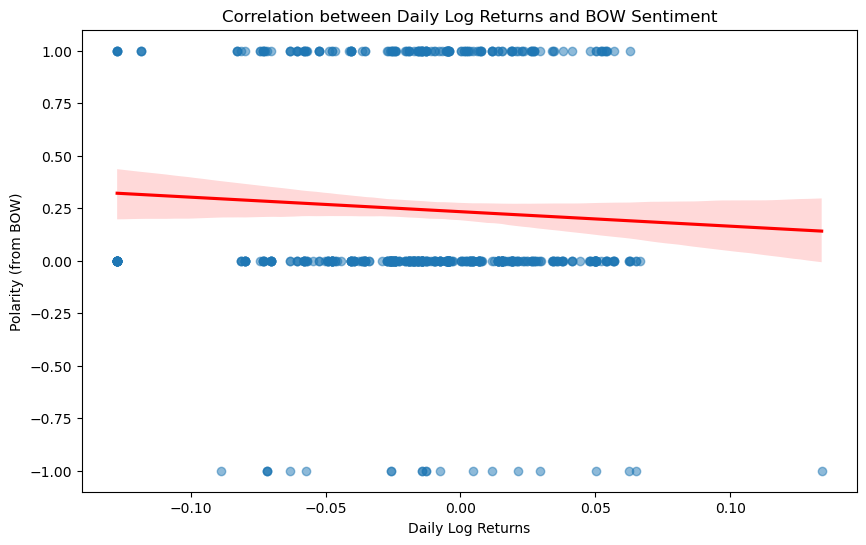

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot with a regression line to visualize the correlation
plt.figure(figsize=(10, 6))
sns.regplot(x=merged_stock["daily_log_returns"], y=merged_stock["BOW"], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Add labels and title
plt.xlabel("Daily Log Returns")
plt.ylabel("Polarity (from BOW)")
plt.title("Correlation between Daily Log Returns and BOW Sentiment")

# Display the plot
plt.show()

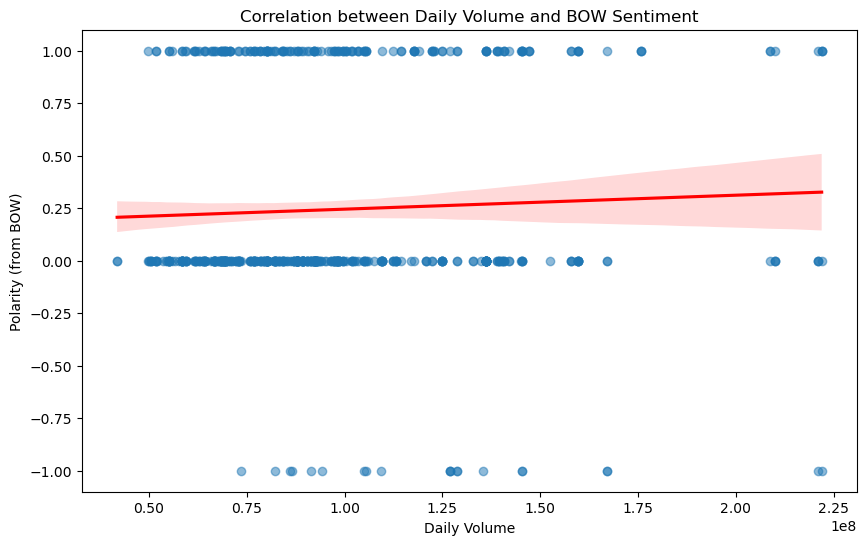

In [28]:
# Create a scatter plot with a regression line to visualize the correlation
plt.figure(figsize=(10, 6))
sns.regplot(x=merged_stock["Volume"], y=merged_stock["BOW"], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Add labels and title
plt.xlabel("Daily Volume")
plt.ylabel("Polarity (from BOW)")
plt.title("Correlation between Daily Volume and BOW Sentiment")

# Display the plot
plt.show()

# Transformer-Based Models

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/madelynmao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### calculate merged_stock["tbm"]

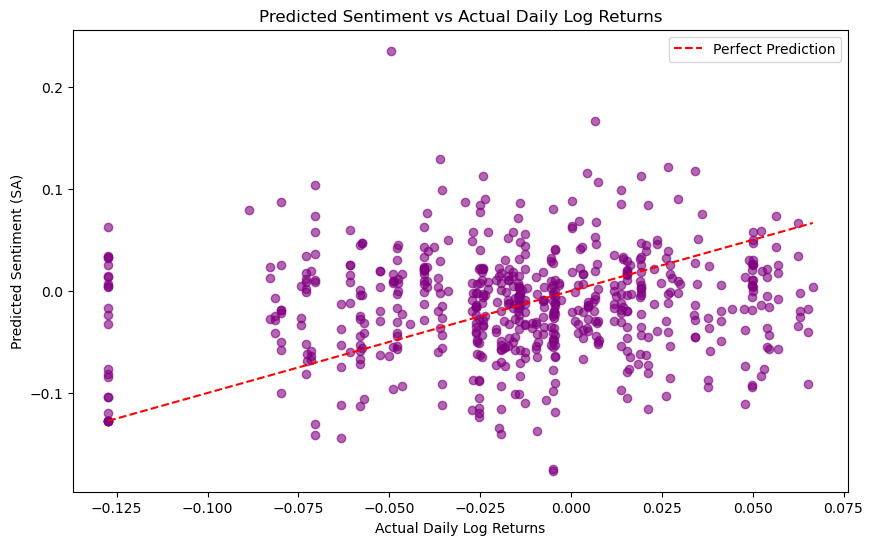

MSE: 0.0038551936772411493


In [55]:
from sklearn.metrics import mean_squared_error

# Starting predictions after 30 datapoints
start_point = 30

# Prepare vectorizer
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))

# Lists to store predictions and actual values
predictions = []
actual_values = []

# Loop over the data starting from 'start_point'
for i in range(start_point, len(merged_stock)):
    # Use data up to the current point for training
    X_train = merged_stock['content'][:i]
    y_train = merged_stock['daily_log_returns'][:i]

    # Convert the content text to vectors
    X_train_vec = vectorizer.fit_transform(X_train)

    # Train the Ridge regression model
    model = Ridge()
    model.fit(X_train_vec, y_train)

    # Predict the next value (on the current point)
    X_test_vec = vectorizer.transform([merged_stock['content'].iloc[i]])
    prediction = model.predict(X_test_vec)

    # Store the prediction and actual value
    predictions.append(prediction[0])
    actual_values.append(merged_stock['daily_log_returns'].iloc[i])

# Convert lists to NumPy arrays for plotting
predictions = np.array(predictions)
actual_values = np.array(actual_values)

# Plotting the results
plt.figure(figsize=(10, 6))

# Scatter plot: X-axis = actual daily log returns, Y-axis = predicted sentiment (SA)
plt.scatter(actual_values, predictions, color='purple', alpha=0.6)

# Adding a reference line (y=x) for perfect prediction
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Prediction')

# Adding labels and title
plt.xlabel('Actual Daily Log Returns')
plt.ylabel('Predicted Sentiment (SA)')
plt.title('Predicted Sentiment vs Actual Daily Log Returns')
plt.legend()

# Show the plot
plt.show()

# Optionally, evaluate the model using Mean Squared Error
print("MSE:", mean_squared_error(actual_values, predictions))

In [56]:
# Initialize a column with NaN values
merged_stock["tbm"] = np.nan

# Populate the column starting from the 30th index
merged_stock.loc[start_point:start_point + len(predictions) - 1, "tbm"] = predictions


In [76]:
# Calculate the correlation
correlation = merged_stock['tbm'].corr(merged_stock['daily_log_returns'])
print(f"Correlation: {correlation}")

Correlation: 0.11239315498860424


In [57]:
merged_stock.head(35)

,date,source,title,link,content,Open,High,Low,Close,Volume,daily_log_returns,percent_change,text_blob,vader,BOW,tbm,tbm_vol
0,2022-01-03,The New York Observer,"Tesla Crushed Every Expectation in 2021, Kicki...",https://www.proquest.com/usnews/docview/261613...,A Tesla Model X on display at the 3rd China In...,382.58,400.36,378.68,399.93,97209777,-0.072459,4.534999,0.090058,0.3340,1,NaN,NaN
1,2022-01-13,Wall Street Journal (Online),"Elon Musk, Hollywood Actors Criticize Californ...",https://www.proquest.com/usnews/docview/261928...,\nA proposal to cut incentives for rooftop sol...,369.69,371.87,342.18,343.85,72924421,0.028734,-6.989640,0.040181,0.9210,0,NaN,NaN
2,2022-01-14,Wall Street Journal (Online),Elon Musk-Backed EV Battery Technology Rises t...,https://www.proquest.com/usnews/docview/261953...,\nA less-expensive battery technology champion...,339.96,350.67,337.79,349.87,66989401,0.003792,2.915049,0.066459,0.9691,0,NaN,NaN
3,2022-01-18,USA Today (Online),World's 10 richest men double wealth in the pa...,https://www.proquest.com/usnews/docview/262073...,As the rest of the world suffered financially ...,342.20,356.93,338.69,343.50,66989401,0.003792,0.379895,0.065909,0.9912,0,NaN,NaN
4,2022-01-18,The New York Observer,Elon Musk Reacts to Tesla Competitor’s Sunday ...,https://www.proquest.com/usnews/docview/262090...,The Dawn Project’s full-page advertisement in ...,342.20,356.93,338.69,343.50,152375129,0.027504,0.379895,0.091639,0.5932,0,NaN,NaN
5,2022-01-24,Wall Street Journal (Online),Tesla Countersues JPMorgan in Fight Over Warra...,https://www.proquest.com/usnews/docview/262227...,\nTesla Inc. countersued JPMorgan Chase & Co. ...,301.59,311.17,283.82,310.00,86595900,0.004584,2.788554,0.043004,-0.9358,-1,NaN,NaN
6,2022-01-25,USA Today (Online),Elon Musk says he'll eat a Happy Meal if McDon...,https://www.proquest.com/usnews/docview/262265...,Elon Musk tweeted on Tuesday that he would eat...,304.73,317.09,301.07,306.13,86595900,0.004584,0.459423,0.196140,0.9948,0,NaN,NaN
7,2022-01-25,Wall Street Journal (Online),Elon Musk Urges McDonald's to Accept Dogecoin ...,https://www.proquest.com/usnews/docview/262248...,\nElon Musk wants McDonald's Corp. to start ac...,304.73,317.09,301.07,306.13,104867283,-0.015906,0.459423,0.164026,0.9756,0,NaN,NaN
8,2022-01-26,Wall Street Journal (Online),Elon Musk Urges McDonald's to Accept Dogecoin ...,https://www.proquest.com/usnews/docview/262260...,\nElon Musk wants McDonald's Corp. to start ac...,317.48,329.23,302.00,312.47,104867283,-0.015906,-1.578052,0.143523,0.9788,0,NaN,NaN
9,2022-01-26,Barron's (Online),Musk Declares Cybertruck 'Awesome' as Tesla St...,https://www.proquest.com/usnews/docview/262264...,\nTesla CEO Elon Musk has been tweeting ahead ...,317.48,329.23,302.00,312.47,104867283,-0.015906,-1.578052,0.147892,0.9766,1,NaN,NaN


### calculate merged_stock["tmb_vol"]

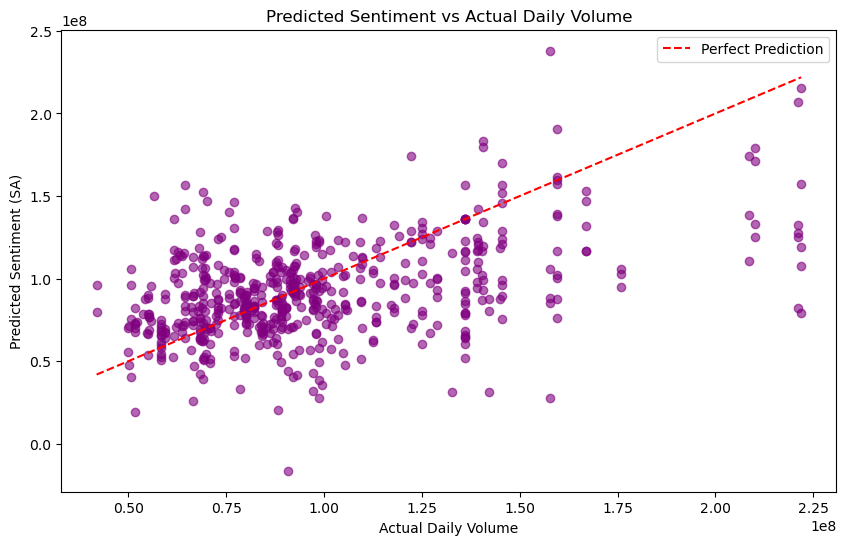

MSE: 1147554430618006.2


In [58]:
# VOLUME

# Starting predictions after 30 datapoints
start_point = 30

# Prepare vectorizer
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))

# Lists to store predictions and actual values
predictions_v = []
actual_values = []

# Loop over the data starting from 'start_point'
for i in range(start_point, len(merged_stock)):
    # Use data up to the current point for training
    X_train = merged_stock['content'][:i]
    y_train = merged_stock['Volume'][:i]

    # Convert the content text to vectors
    X_train_vec = vectorizer.fit_transform(X_train)

    # Train the Ridge regression model
    model = Ridge()
    model.fit(X_train_vec, y_train)

    # Predict the next value (on the current point)
    X_test_vec = vectorizer.transform([merged_stock['content'].iloc[i]])
    prediction = model.predict(X_test_vec)

    # Store the prediction and actual value
    predictions_v.append(prediction[0])
    actual_values.append(merged_stock['Volume'].iloc[i])

# Convert lists to NumPy arrays for plotting
predictions_v = np.array(predictions_v)
actual_values = np.array(actual_values)

# Plotting the results
plt.figure(figsize=(10, 6))

# Scatter plot: X-axis = actual daily log returns, Y-axis = predicted sentiment (SA)
plt.scatter(actual_values, predictions_v, color='purple', alpha=0.6)

# Adding a reference line (y=x) for perfect prediction
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Prediction')

# Adding labels and title
plt.xlabel('Actual Daily Volume')
plt.ylabel('Predicted Sentiment (SA)')
plt.title('Predicted Sentiment vs Actual Daily Volume')
plt.legend()

# Show the plot
plt.show()

# Optionally, evaluate the model using Mean Squared Error
print("MSE:", mean_squared_error(actual_values, predictions_v))

In [61]:
# Initialize a column with NaN values
merged_stock["tbm_vol"] = np.nan

# Populate the column starting from the 30th index
merged_stock.loc[start_point:start_point + len(predictions_v) - 1, "tbm_vol"] = predictions_v

In [62]:
import numpy as np

# Calculate Pearson's correlation coefficient
correlation = np.corrcoef(actual_values, predictions_v)[0, 1]

print(f"Correlation Coefficient: {correlation}")


Correlation Coefficient: 0.45566155352298665


In [63]:
merged_stock.head(35)

,date,source,title,link,content,Open,High,Low,Close,Volume,daily_log_returns,percent_change,text_blob,vader,BOW,tbm,tbm_vol
0,2022-01-03,The New York Observer,"Tesla Crushed Every Expectation in 2021, Kicki...",https://www.proquest.com/usnews/docview/261613...,A Tesla Model X on display at the 3rd China In...,382.58,400.36,378.68,399.93,97209777,-0.072459,4.534999,0.090058,0.3340,1,NaN,NaN
1,2022-01-13,Wall Street Journal (Online),"Elon Musk, Hollywood Actors Criticize Californ...",https://www.proquest.com/usnews/docview/261928...,\nA proposal to cut incentives for rooftop sol...,369.69,371.87,342.18,343.85,72924421,0.028734,-6.989640,0.040181,0.9210,0,NaN,NaN
2,2022-01-14,Wall Street Journal (Online),Elon Musk-Backed EV Battery Technology Rises t...,https://www.proquest.com/usnews/docview/261953...,\nA less-expensive battery technology champion...,339.96,350.67,337.79,349.87,66989401,0.003792,2.915049,0.066459,0.9691,0,NaN,NaN
3,2022-01-18,USA Today (Online),World's 10 richest men double wealth in the pa...,https://www.proquest.com/usnews/docview/262073...,As the rest of the world suffered financially ...,342.20,356.93,338.69,343.50,66989401,0.003792,0.379895,0.065909,0.9912,0,NaN,NaN
4,2022-01-18,The New York Observer,Elon Musk Reacts to Tesla Competitor’s Sunday ...,https://www.proquest.com/usnews/docview/262090...,The Dawn Project’s full-page advertisement in ...,342.20,356.93,338.69,343.50,152375129,0.027504,0.379895,0.091639,0.5932,0,NaN,NaN
5,2022-01-24,Wall Street Journal (Online),Tesla Countersues JPMorgan in Fight Over Warra...,https://www.proquest.com/usnews/docview/262227...,\nTesla Inc. countersued JPMorgan Chase & Co. ...,301.59,311.17,283.82,310.00,86595900,0.004584,2.788554,0.043004,-0.9358,-1,NaN,NaN
6,2022-01-25,USA Today (Online),Elon Musk says he'll eat a Happy Meal if McDon...,https://www.proquest.com/usnews/docview/262265...,Elon Musk tweeted on Tuesday that he would eat...,304.73,317.09,301.07,306.13,86595900,0.004584,0.459423,0.196140,0.9948,0,NaN,NaN
7,2022-01-25,Wall Street Journal (Online),Elon Musk Urges McDonald's to Accept Dogecoin ...,https://www.proquest.com/usnews/docview/262248...,\nElon Musk wants McDonald's Corp. to start ac...,304.73,317.09,301.07,306.13,104867283,-0.015906,0.459423,0.164026,0.9756,0,NaN,NaN
8,2022-01-26,Wall Street Journal (Online),Elon Musk Urges McDonald's to Accept Dogecoin ...,https://www.proquest.com/usnews/docview/262260...,\nElon Musk wants McDonald's Corp. to start ac...,317.48,329.23,302.00,312.47,104867283,-0.015906,-1.578052,0.143523,0.9788,0,NaN,NaN
9,2022-01-26,Barron's (Online),Musk Declares Cybertruck 'Awesome' as Tesla St...,https://www.proquest.com/usnews/docview/262264...,\nTesla CEO Elon Musk has been tweeting ahead ...,317.48,329.23,302.00,312.47,104867283,-0.015906,-1.578052,0.147892,0.9766,1,NaN,NaN


## Finding correlation between full article and just title for Various sentiment analysis methods
Text Blob
Vader
Bag of Words Vectorization-based Models
LSTM-based Models
Transformer-based Models

### textblob

Correlation: 0.07031607034462516


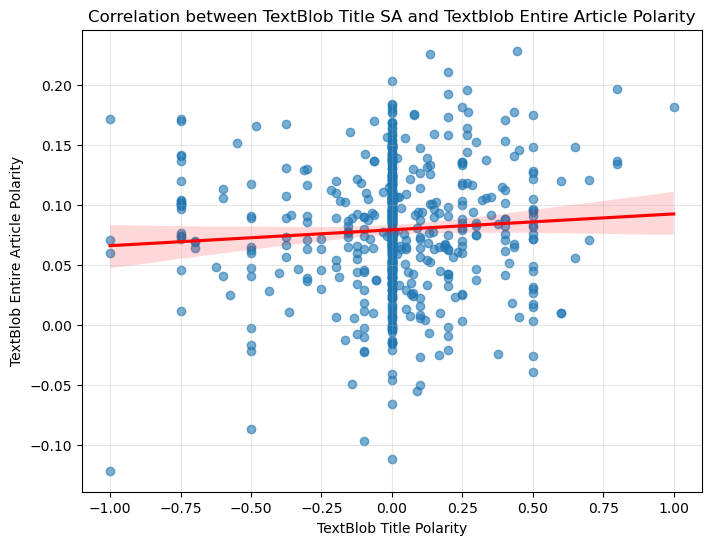

In [65]:
merged_stock['text_blob_title'] = merged_stock['title'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Calculate the correlation
correlation = merged_stock['text_blob_title'].corr(merged_stock['text_blob'])
print(f"Correlation: {correlation}")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='text_blob_title', y='text_blob', data=merged_stock, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Correlation between TextBlob Title SA and Textblob Entire Article Polarity')
plt.xlabel('TextBlob Title Polarity')
plt.ylabel('TextBlob Entire Article Polarity')
plt.grid(alpha=0.3)
plt.show()

### Vader

Correlation: 0.24555599516999355


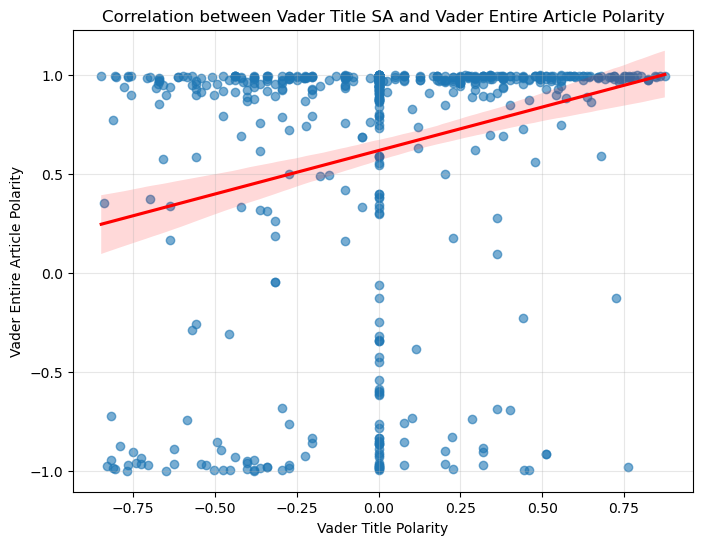

In [66]:
# Apply Vader sentiment analysis to extract only the 'compound' score for each row
merged_stock['vader_title'] = merged_stock['title'].apply(lambda text: sentiment_analyzer.polarity_scores(text)['compound'])

# Calculate the correlation
correlation = merged_stock['vader_title'].corr(merged_stock['vader'])
print(f"Correlation: {correlation}")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='vader_title', y='vader', data=merged_stock, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Correlation between Vader Title SA and Vader Entire Article Polarity')
plt.xlabel('Vader Title Polarity')
plt.ylabel('Vader Entire Article Polarity')
plt.grid(alpha=0.3)
plt.show()

### Bag of Words Vectorization-based Models - decided I am not a fan of the {-1, 0, 1} score options.

### Transformer based model

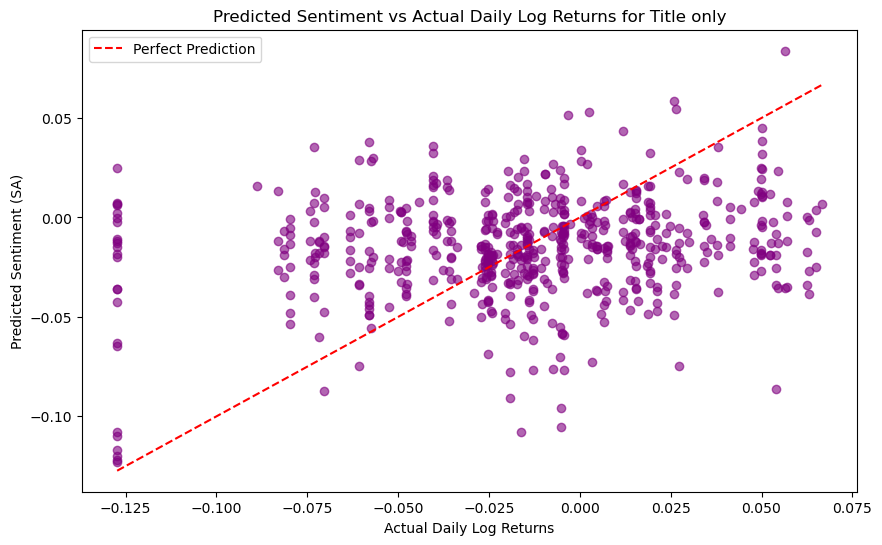

MSE: 0.001949521188925623


In [67]:
# title only - SA with log daily returns
from sklearn.metrics import mean_squared_error

# Starting predictions after 30 datapoints
start_point = 30

# Prepare vectorizer
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))

# Lists to store predictions and actual values
predictions_title = []
actual_values = []

# Loop over the data starting from 'start_point'
for i in range(start_point, len(merged_stock)):
    # Use data up to the current point for training
    X_train = merged_stock['title'][:i]
    y_train = merged_stock['daily_log_returns'][:i]

    # Convert the content text to vectors
    X_train_vec = vectorizer.fit_transform(X_train)

    # Train the Ridge regression model
    model = Ridge()
    model.fit(X_train_vec, y_train)

    # Predict the next value (on the current point)
    X_test_vec = vectorizer.transform([merged_stock['title'].iloc[i]])
    prediction = model.predict(X_test_vec)

    # Store the prediction and actual value
    predictions_title.append(prediction[0])
    actual_values.append(merged_stock['daily_log_returns'].iloc[i])

# Convert lists to NumPy arrays for plotting
predictions_title = np.array(predictions_title)
actual_values = np.array(actual_values)

# Plotting the results
plt.figure(figsize=(10, 6))

# Scatter plot: X-axis = actual daily log returns, Y-axis = predicted sentiment (SA)
plt.scatter(actual_values, predictions_title, color='purple', alpha=0.6)

# Adding a reference line (y=x) for perfect prediction
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Prediction')

# Adding labels and title
plt.xlabel('Actual Daily Log Returns')
plt.ylabel('Predicted Sentiment (SA)')
plt.title('Predicted Sentiment vs Actual Daily Log Returns for Title only')
plt.legend()

# Show the plot
plt.show()

# Optionally, evaluate the model using Mean Squared Error
print("MSE:", mean_squared_error(actual_values, predictions_title))

In [68]:
# Initialize a column with NaN values
merged_stock["tbm_title"] = np.nan

# Populate the column starting from the 30th index
merged_stock.loc[start_point:start_point + len(predictions) - 1, "tbm_title"] = predictions_title

In [78]:
# Calculate the correlation
correlation = merged_stock['tbm_title'].corr(merged_stock['daily_log_returns'])
print(f"Correlation: {correlation}")

Correlation: 0.20734777581928798


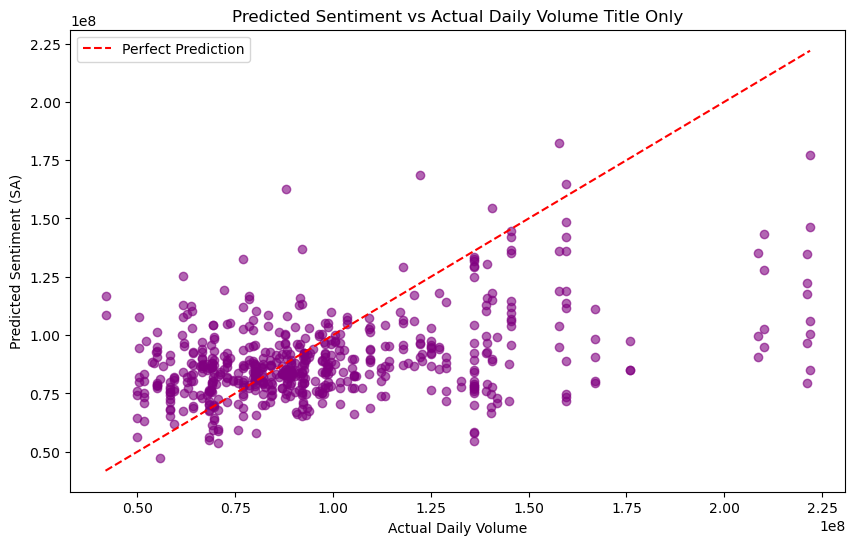

MSE: 1062266514878838.0


In [69]:
# title only - SA with volume
start_point = 30

# Prepare vectorizer
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))

# Lists to store predictions and actual values
predictions_v_title = []
actual_values = []

# Loop over the data starting from 'start_point'
for i in range(start_point, len(merged_stock)):
    # Use data up to the current point for training
    X_train = merged_stock['title'][:i]
    y_train = merged_stock['Volume'][:i]

    # Convert the content text to vectors
    X_train_vec = vectorizer.fit_transform(X_train)

    # Train the Ridge regression model
    model = Ridge()
    model.fit(X_train_vec, y_train)

    # Predict the next value (on the current point)
    X_test_vec = vectorizer.transform([merged_stock['title'].iloc[i]])
    prediction = model.predict(X_test_vec)

    # Store the prediction and actual value
    predictions_v_title.append(prediction[0])
    actual_values.append(merged_stock['Volume'].iloc[i])

# Convert lists to NumPy arrays for plotting
predictions_v_title = np.array(predictions_v_title)
actual_values = np.array(actual_values)

# Plotting the results
plt.figure(figsize=(10, 6))

# Scatter plot: X-axis = actual daily log returns, Y-axis = predicted sentiment (SA)
plt.scatter(actual_values, predictions_v_title, color='purple', alpha=0.6)

# Adding a reference line (y=x) for perfect prediction
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Prediction')

# Adding labels and title
plt.xlabel('Actual Daily Volume')
plt.ylabel('Predicted Sentiment (SA)')
plt.title('Predicted Sentiment vs Actual Daily Volume Title Only')
plt.legend()

# Show the plot
plt.show()

# Optionally, evaluate the model using Mean Squared Error
print("MSE:", mean_squared_error(actual_values, predictions_v_title))

In [79]:
# Initialize a column with NaN values
merged_stock["tbm_vol_title"] = np.nan

# Populate the column starting from the 30th index
merged_stock.loc[start_point:start_point + len(predictions_v_title) - 1, "tbm_vol_title"] = predictions_v_title

In [80]:
# Calculate the correlation
correlation = merged_stock['tbm_vol_title'].corr(merged_stock['Volume'])
print(f"Correlation: {correlation}")

Correlation: 0.42310663663801196


### Correlations with TBM title VS TBM whole article

Correlation: 0.21991620744864457


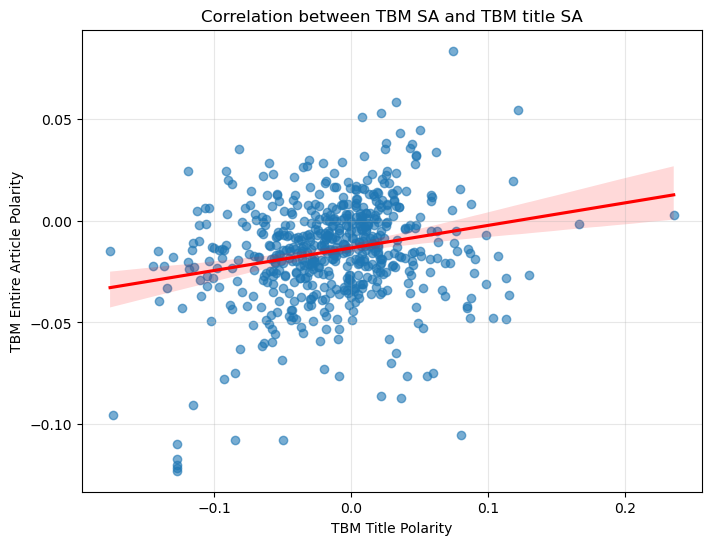

In [71]:
# Calculate the correlation
correlation = merged_stock['tbm'].corr(merged_stock['tbm_title'])
print(f"Correlation: {correlation}")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='tbm', y='tbm_title', data=merged_stock, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Correlation between TBM SA and TBM title SA')
plt.xlabel('TBM Title Polarity')
plt.ylabel('TBM Entire Article Polarity')
plt.grid(alpha=0.3)
plt.show()

Correlation: 0.44706371249636556


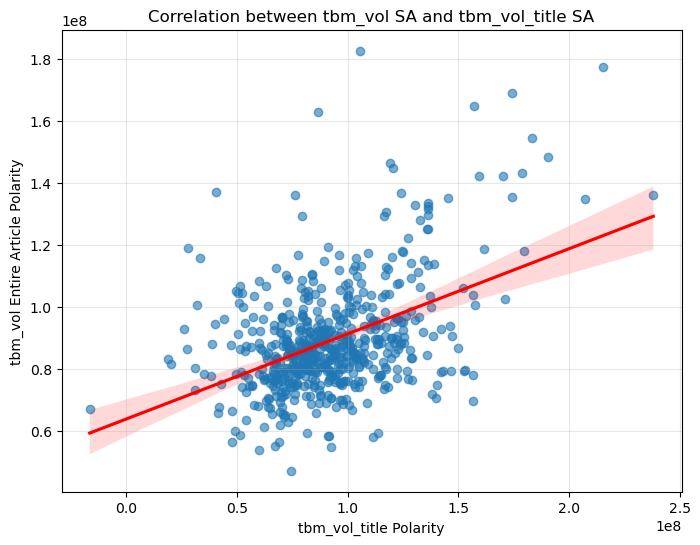

In [73]:
# Calculate the correlation
correlation = merged_stock['tbm_vol'].corr(merged_stock['tbm_vol_title'])
print(f"Correlation: {correlation}")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='tbm_vol', y='tbm_vol_title', data=merged_stock, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Correlation between tbm_vol SA and tbm_vol_title SA')
plt.xlabel('tbm_vol_title Polarity')
plt.ylabel('tbm_vol Entire Article Polarity')
plt.grid(alpha=0.3)
plt.show()

NameError: name 'merged_stock' is not defined